In [62]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

In [32]:
data_all = np.load('/rdf/data/physionet.org/processed_DA/ptbxl/100hz/test_dict_12lead.npy', allow_pickle=True).item()
data = torch.Tensor(data_all['ECG_signal'][0]).permute(1,0).unsqueeze(0)

In [33]:
data.shape

torch.Size([1, 12, 1000])

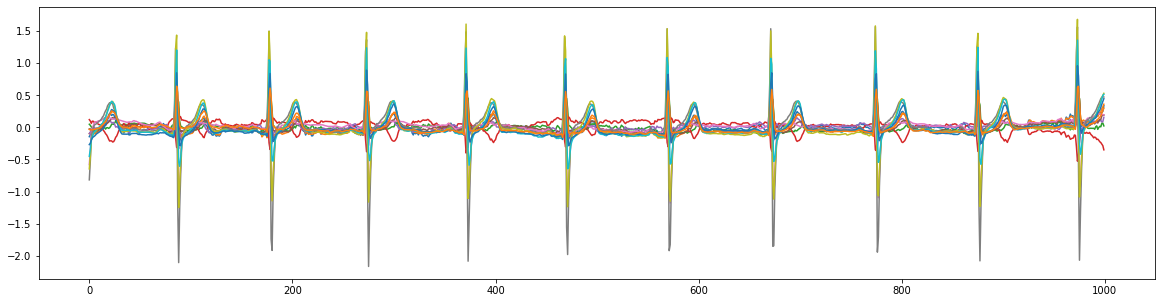

In [36]:
plt.figure(figsize=(20,5))
plt.plot(data[0].T)

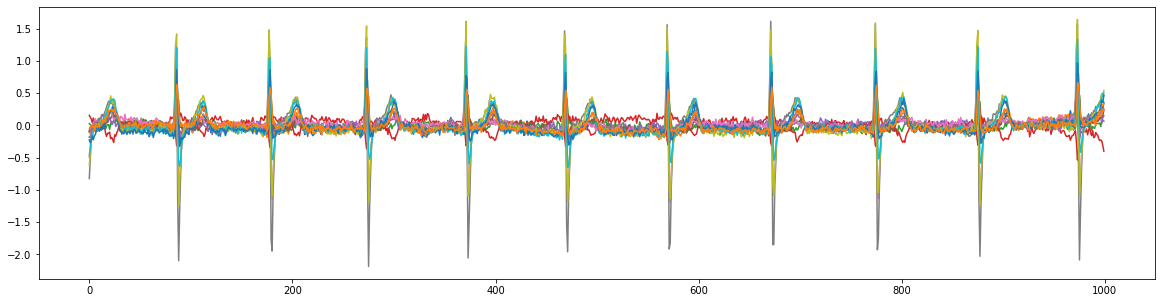

In [41]:
## Jittering
def jitter(x, sigma=0.03):
    return x + torch.normal(mean=0., std=sigma, size=x.shape)

plt.figure(figsize=(20,5))
plt.plot(jitter(data)[0].T)

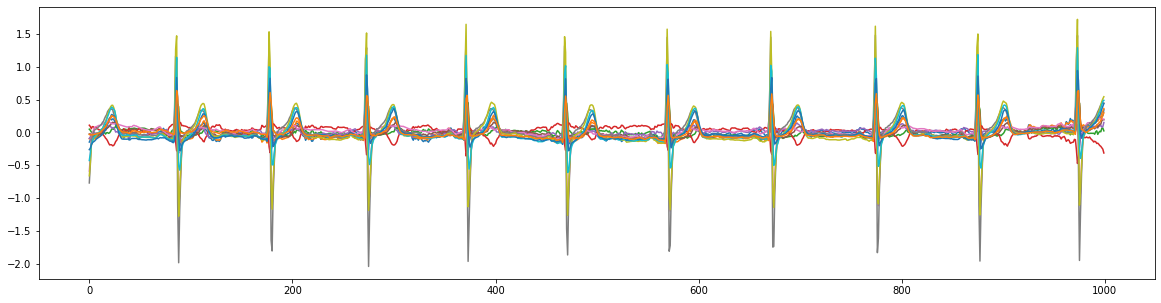

In [57]:
## Scaling
def scaling(x, sigma=0.03):
    factor = torch.normal(mean=1., std=sigma, size=(x.shape[:2]))
    output = x * factor.unsqueeze(-1)
    return output

plt.figure(figsize=(20,5))
plt.plot(scaling(data)[0].T)

tensor([0.0939, 0.2732, 0.3576, 0.7177, 0.2103, 0.8626, 0.0792, 0.6655, 0.8913,
        0.5511, 0.0129, 0.7846]) tensor([0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.])


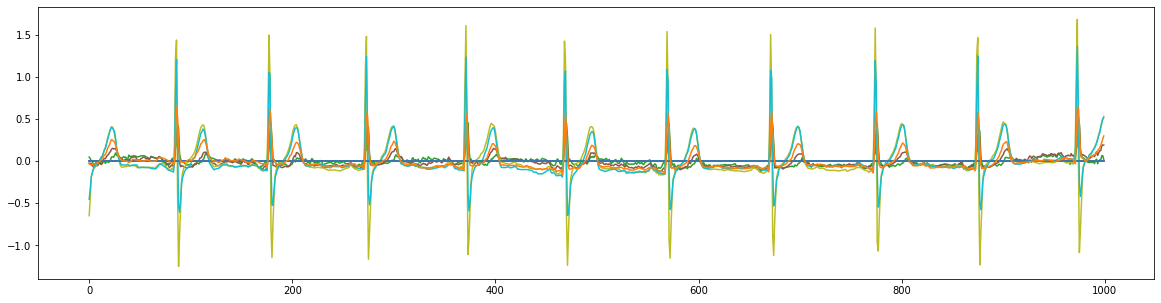

In [68]:
## Rotation

def rotation(x, flip_prob):
    """
    x.shape = [batchsize, channel, features]
    """
    flip = torch.bernoulli(flip_prob)
    print(flip_prob, flip)
    output =  flip.view(1, -1, 1) * x
    return output

plt.figure(figsize=(20,5))
plt.plot(rotation(data, torch.rand(data.size(1)))[0].T)